# Data Preperation

In [1]:
#ungsugoe 5
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install lpips

     |████████████████████████████████| 53 kB 1.6 MB/s 


In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import requests
import tensorflow_datasets as tfds
import tqdm
import tensorflow_hub as hub
import os
import gc
import shutil
import re
import torch
import lpips
import cv2
import time
import logging
import urllib.request
from scipy import ndimage

In [4]:
class TqdmLoggingHandler(logging.Handler):
    def __init__(self, level=logging.NOTSET):
        super().__init__(level)

    def emit(self, record):
        try:
            msg = self.format(record)
            tqdm.tqdm.write(msg)
            self.flush()
        except (KeyboardInterrupt, SystemExit):
            raise
        except:
            self.handleError(record)  
log = logging.getLogger(__name__)
log.setLevel(logging.INFO)
log.addHandler(TqdmLoggingHandler())

## Data path


In [5]:
set5_save_path='/content/drive/MyDrive/data/Set5/'
set14_save_path='/content/drive/MyDrive/data/Set14/'
div2k_save_path='/content/drive/MyDrive/data/div2k_hr/DIV2K_train_HR'
div8k_save_path='/content/drive/MyDrive/data/DIV8K/'
flickr2k_save_path='/content/drive/MyDrive/data/Flickr2k/'

## Pipeline Configuration

In [6]:
PATCH_SIZE = 96
LR_SCALE = 4
BATCH_SIZE = 16

buffer_size = 1024
patch_per_image = 128
LOG_STEP=1000
log_dir='/content/drive/MyDrive/logs/Ultimate-SR/ESRGAN-MSE-100K'
model_type='SRGAN_MSE'
FP16=False
image_dtype=tf.float32

use_div2k=True
use_div8k=False

blur_detection=True
MSE_after_bicubic=False
use_noise=True
progressive_training=False
espcn_growing=True
lr_reference=False

plot_PSNR=True
plot_LPIPS=True

init=tf.keras.initializers.GlorotUniform()  

## Bicubic Resizing

In [8]:
def imresize_np(img, scale, antialiasing=True):
    in_H, in_W, in_C = img.shape

    _, out_H, out_W = in_C, np.ceil(in_H * scale), np.ceil(in_W * scale)
    out_H, out_W = out_H.astype(np.int64), out_W.astype(np.int64)
    kernel_width = 4
    kernel = 'cubic'
    weights_H, indices_H, sym_len_Hs, sym_len_He = _calculate_weights_indices(
        in_H, out_H, scale, kernel, kernel_width, antialiasing)
    weights_W, indices_W, sym_len_Ws, sym_len_We = _calculate_weights_indices(
        in_W, out_W, scale, kernel, kernel_width, antialiasing)
    img_aug = np.zeros(((in_H + sym_len_Hs + sym_len_He), in_W, in_C))
    img_aug[sym_len_Hs:sym_len_Hs + in_H] = img

    sym_patch = img[:sym_len_Hs, :, :]
    sym_patch_inv = sym_patch[::-1]
    img_aug[0:sym_len_Hs] = sym_patch_inv

    sym_patch = img[-sym_len_He:, :, :]
    sym_patch_inv = sym_patch[::-1]
    img_aug[sym_len_Hs + in_H:sym_len_Hs + in_H + sym_len_He] = sym_patch_inv

    out_1 = np.zeros((out_H, in_W, in_C))
    kernel_width = weights_H.shape[1]
    for i in range(out_H):
        idx = int(indices_H[i][0])
        out_1[i, :, 0] = weights_H[i].dot(
            img_aug[idx:idx + kernel_width, :, 0].transpose(0, 1))
        out_1[i, :, 1] = weights_H[i].dot(
            img_aug[idx:idx + kernel_width, :, 1].transpose(0, 1))
        out_1[i, :, 2] = weights_H[i].dot(
            img_aug[idx:idx + kernel_width, :, 2].transpose(0, 1))
    out_1_aug = np.zeros((out_H, in_W + sym_len_Ws + sym_len_We, in_C))
    out_1_aug[:, sym_len_Ws:sym_len_Ws + in_W] = out_1

    sym_patch = out_1[:, :sym_len_Ws, :]
    sym_patch_inv = sym_patch[:, ::-1]
    out_1_aug[:, 0:sym_len_Ws] = sym_patch_inv

    sym_patch = out_1[:, -sym_len_We:, :]
    sym_patch_inv = sym_patch[:, ::-1]
    out_1_aug[:, sym_len_Ws + in_W:sym_len_Ws + in_W + sym_len_We] = \
        sym_patch_inv

    out_2 = np.zeros((out_H, out_W, in_C))
    kernel_width = weights_W.shape[1]
    for i in range(out_W):
        idx = int(indices_W[i][0])
        out_2[:, i, 0] = out_1_aug[:, idx:idx + kernel_width, 0].dot(
            weights_W[i])
        out_2[:, i, 1] = out_1_aug[:, idx:idx + kernel_width, 1].dot(
            weights_W[i])
        out_2[:, i, 2] = out_1_aug[:, idx:idx + kernel_width, 2].dot(
            weights_W[i])

    return out_2.clip(0, 255)


def _cubic(x):
    absx = np.abs(x)
    absx2 = absx ** 2
    absx3 = absx ** 3
    return (1.5 * absx3 - 2.5 * absx2 + 1) * ((absx <= 1).astype(np.float64)) \
        + (-0.5 * absx3 + 2.5 * absx2 - 4 * absx + 2) * (
            ((absx > 1) * (absx <= 2)).astype(np.float64))


def _calculate_weights_indices(in_length, out_length, scale, kernel,
                               kernel_width, antialiasing):
    if (scale < 1) and (antialiasing):
        kernel_width = kernel_width / scale

    x = np.linspace(1, out_length, out_length)
    u = x / scale + 0.5 * (1 - 1 / scale)

    left = np.floor(u - kernel_width / 2)
    P = (np.ceil(kernel_width) + 2).astype(np.int32)
    indices = left.reshape(int(out_length), 1).repeat(P, axis=1) + \
        np.linspace(0, P - 1, P).reshape(1, int(P)).repeat(out_length, axis=0)
    distance_to_center = \
        u.reshape(int(out_length), 1).repeat(P, axis=1) - indices
    if (scale < 1) and (antialiasing):
        weights = scale * _cubic(distance_to_center * scale)
    else:
        weights = _cubic(distance_to_center)
    weights_sum = np.sum(weights, 1).reshape(int(out_length), 1)
    weights = weights / weights_sum.repeat(P, axis=1)
    weights_zero_tmp = np.sum((weights == 0), 0)
    if not np.isclose(weights_zero_tmp[0], 0, rtol=1e-6):
        indices = indices[:, 1:1 + int(P) - 2]
        weights = weights[:, 1:1 + int(P) - 2]
    if not np.isclose(weights_zero_tmp[-1], 0, rtol=1e-6):
        indices = indices[:, 0:0 + int(P) - 2]
        weights = weights[:, 0:0 + int(P) - 2]
    weights = weights.copy()
    indices = indices.copy()
    sym_len_s = -indices.min() + 1
    sym_len_e = indices.max() - in_length
    indices = indices + sym_len_s - 1
    return weights, indices, int(sym_len_s), int(sym_len_e)

## Data Loader 

In [9]:
@tf.function()
def read_image(path):
  image = tf.io.read_file(path)
  image = tf.image.decode_jpeg(image)
  return image

def generate_val_data(image):
  # Returns (LR, HR)
  image=tf.dtypes.cast(image, tf.float32) / 255.0
  image = tf.image.resize(image,((image.shape[0]//LR_SCALE) * LR_SCALE,(image.shape[1]//LR_SCALE)*LR_SCALE) ,method=tf.image.ResizeMethod.BICUBIC).numpy()
  lr = imresize_np(image, 1/LR_SCALE)
  return lr,image * 2 - 1

def generate_data(image):
  cropped=tf.dtypes.cast(tf.image.random_crop(image / 255,(PATCH_SIZE,PATCH_SIZE,3)),image_dtype)

  cropped=tf.image.random_flip_left_right(cropped)
  rot_t=np.random.randint(4)
  for _ in range(rot_t):
    cropped=tf.image.rot90(cropped)
    
  if blur_detection:
    var=cv2.Laplacian(cropped.numpy(), cv2.CV_32F).var() * 256 * 256

    if var > 100: #Clear Image
      lr = imresize_np(cropped, 1/LR_SCALE)
      return lr,cropped * 2 - 1
    else:         #Blurry Image
      return None 
  else:
    lr = imresize_np(cropped, 1/LR_SCALE)
    return lr,cropped * 2 - 1

def generate_patches(im):
  # Fetch n patches from image sample and append to buffer
  global buffer
  
  for _ in range(patch_per_image):
    res = generate_data(im)
    if not res is None:
      buffer.append(res)

def load_image_batch():
  global buffer, train_iter
  lr_list, hr_list = [], []
  # Fill the buffer until size >= `buffer_size`
  while len(buffer) < buffer_size:
    next=train_iter.get_next_as_optional()
    if next.has_value()==False:   #Reset iterator after reahing end of dataset
      train_iter = iter(train_images)
      continue

    generate_patches(next.get_value())
  # Load batch_size patches from buffer
  for _ in range(BATCH_SIZE):
    idx = np.random.randint(len(buffer))

    lr_list.append(buffer[idx][0])
    hr_list.append(buffer[idx][1])

    del buffer[idx]
    
  return (np.array(lr_list), np.array(hr_list))


if use_div8k:
  div8k_list=[os.path.join(div8k_save_path, x) for x in os.listdir(div8k_save_path)]
  train_path = tf.data.Dataset.from_tensor_slices(div8k_list)
elif use_div2k:
  div2k_list=[os.path.join(div2k_save_path, x) for x in os.listdir(div2k_save_path)]
  train_path = tf.data.Dataset.from_tensor_slices(div2k_list)
  set5_path = tf.data.Dataset.list_files(set5_save_path+'*.png', shuffle=False)
  set14_path = tf.data.Dataset.list_files(set14_save_path+'*.png', shuffle=False)

train_images = train_path.map(read_image, num_parallel_calls=tf.data.AUTOTUNE)
set5_dataset = set5_path.map(read_image, num_parallel_calls=tf.data.AUTOTUNE)
set14_dataset = set14_path.map(read_image, num_parallel_calls=tf.data.AUTOTUNE)

buffer = []  # List of [(lr1, hr1), (lr2, hr2), ...] 
train_iter = iter(train_images)

set5=[]
for image in set5_dataset:
  set5.append(generate_val_data(image))
set14=[]
for image in set5_dataset:
  set14.append(generate_val_data(image))

# Generator Architectures

## Utils

In [10]:
class SelfAttention(tf.keras.Model):
  def __init__(self):
    super(SelfAttention, self).__init__()

  def build(self, input_shape):
    self.num_channels=input_shape[-1]
    self.hw = input_shape[1]*input_shape[2]
    self.conv_f=tf.keras.layers.Conv2D(self.num_channels // 8, 1)
    self.conv_g=tf.keras.layers.Conv2D(self.num_channels // 8, 1)
    self.conv_h=tf.keras.layers.Conv2D(self.num_channels//2, 1)
    self.conv_o=tf.keras.layers.Conv2D(self.num_channels, 1)

  def call(self, x):
    bs = x.shape[0]
    f = self.conv_f(x)  # [bs, h, w, c']
    g = self.conv_g(x)  # [bs, h, w, c']
    h = self.conv_h(x)  # [bs, h, w, c]

    f=tf.keras.layers.Reshape([self.hw, f.shape[-1]])(f)
    g=tf.keras.layers.Reshape([self.hw, g.shape[-1]])(g)
    h=tf.keras.layers.Reshape([self.hw, h.shape[-1]])(h)
    # N = h * w
    s = tf.matmul(g, f, transpose_b=True)  # # [bs, N, N]
    beta = tf.nn.softmax(s)  # attention map

    o = tf.matmul(beta, h)  # [bs, N, C]
    o = tf.keras.layers.Reshape([x.shape[1], x.shape[2], self.num_channels//2])(o)
    o = self.conv_o(o)
      # [bs, h, w, C]
    return x + o

class ApplyNoise(tf.keras.Model):
  def __init__(self):
    super(ApplyNoise, self).__init__()

  def build(self, input_shape):
    self.channels = input_shape[-1]
    self.channel_wise = self.add_weight("kernel", shape=(self.channels,), trainable=True)

  def call(self, x):
    noise = tf.random.normal(tf.shape(x), dtype=x.dtype)
    return x + noise * self.channel_wise


## 4x Architectures

### Bicubic

In [11]:
class Bicubic4x(tf.keras.Model):
  def __init__(self):
    super().__init__()

  def call(self, inputs):
    result = tf.image.resize(inputs,(inputs.shape[0] * 4, inputs.shape[1] * 4))
    return result
Bicubic=Bicubic4x()

### SRGAN/SRResNet 

In [12]:
def residual_block_gen(ch=64,k_s=3,st=1):
  model=tf.keras.Sequential([
    tf.keras.layers.Conv2D(ch,k_s,strides=(st,st),padding='same',kernel_initializer=init),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.PReLU(shared_axes=[1, 2]),
    tf.keras.layers.Conv2D(ch,k_s,strides=(st,st),padding='same',kernel_initializer=init),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.PReLU(shared_axes=[1, 2])
  ])
  return model

def Upsample_block(x, ch=256, k_s=3, st=1):
    x = tf.keras.layers.Conv2D(ch,k_s, strides=(st,st), padding='same',kernel_initializer=init)(x)
    x = tf.nn.depth_to_space(x, 2) # Subpixel pixelshuffler
    x = tf.keras.layers.LeakyReLU()(x)
    return x

input_lr=tf.keras.layers.Input(shape=(None,None,3))
input_conv=tf.keras.layers.Conv2D(64,3,padding='same',kernel_initializer=init)(input_lr)
input_conv=tf.keras.layers.PReLU(shared_axes=[1, 2])(input_conv)

SRRes=input_conv
for x in range(5):
  res_output=residual_block_gen()(SRRes)
  SRRes=tf.keras.layers.Add()([SRRes,res_output])

SRRes=tf.keras.layers.Conv2D(64,3,padding='same',kernel_initializer=init)(SRRes)
SRRes=tf.keras.layers.BatchNormalization()(SRRes)
SRRes=tf.keras.layers.Add()([SRRes,input_conv])

SRRes=Upsample_block(SRRes)
SRRes=Upsample_block(SRRes)

output_sr=tf.keras.layers.Conv2D(3,3,padding='same',kernel_initializer=init)(SRRes)

generator=tf.keras.models.Model(input_lr,output_sr)

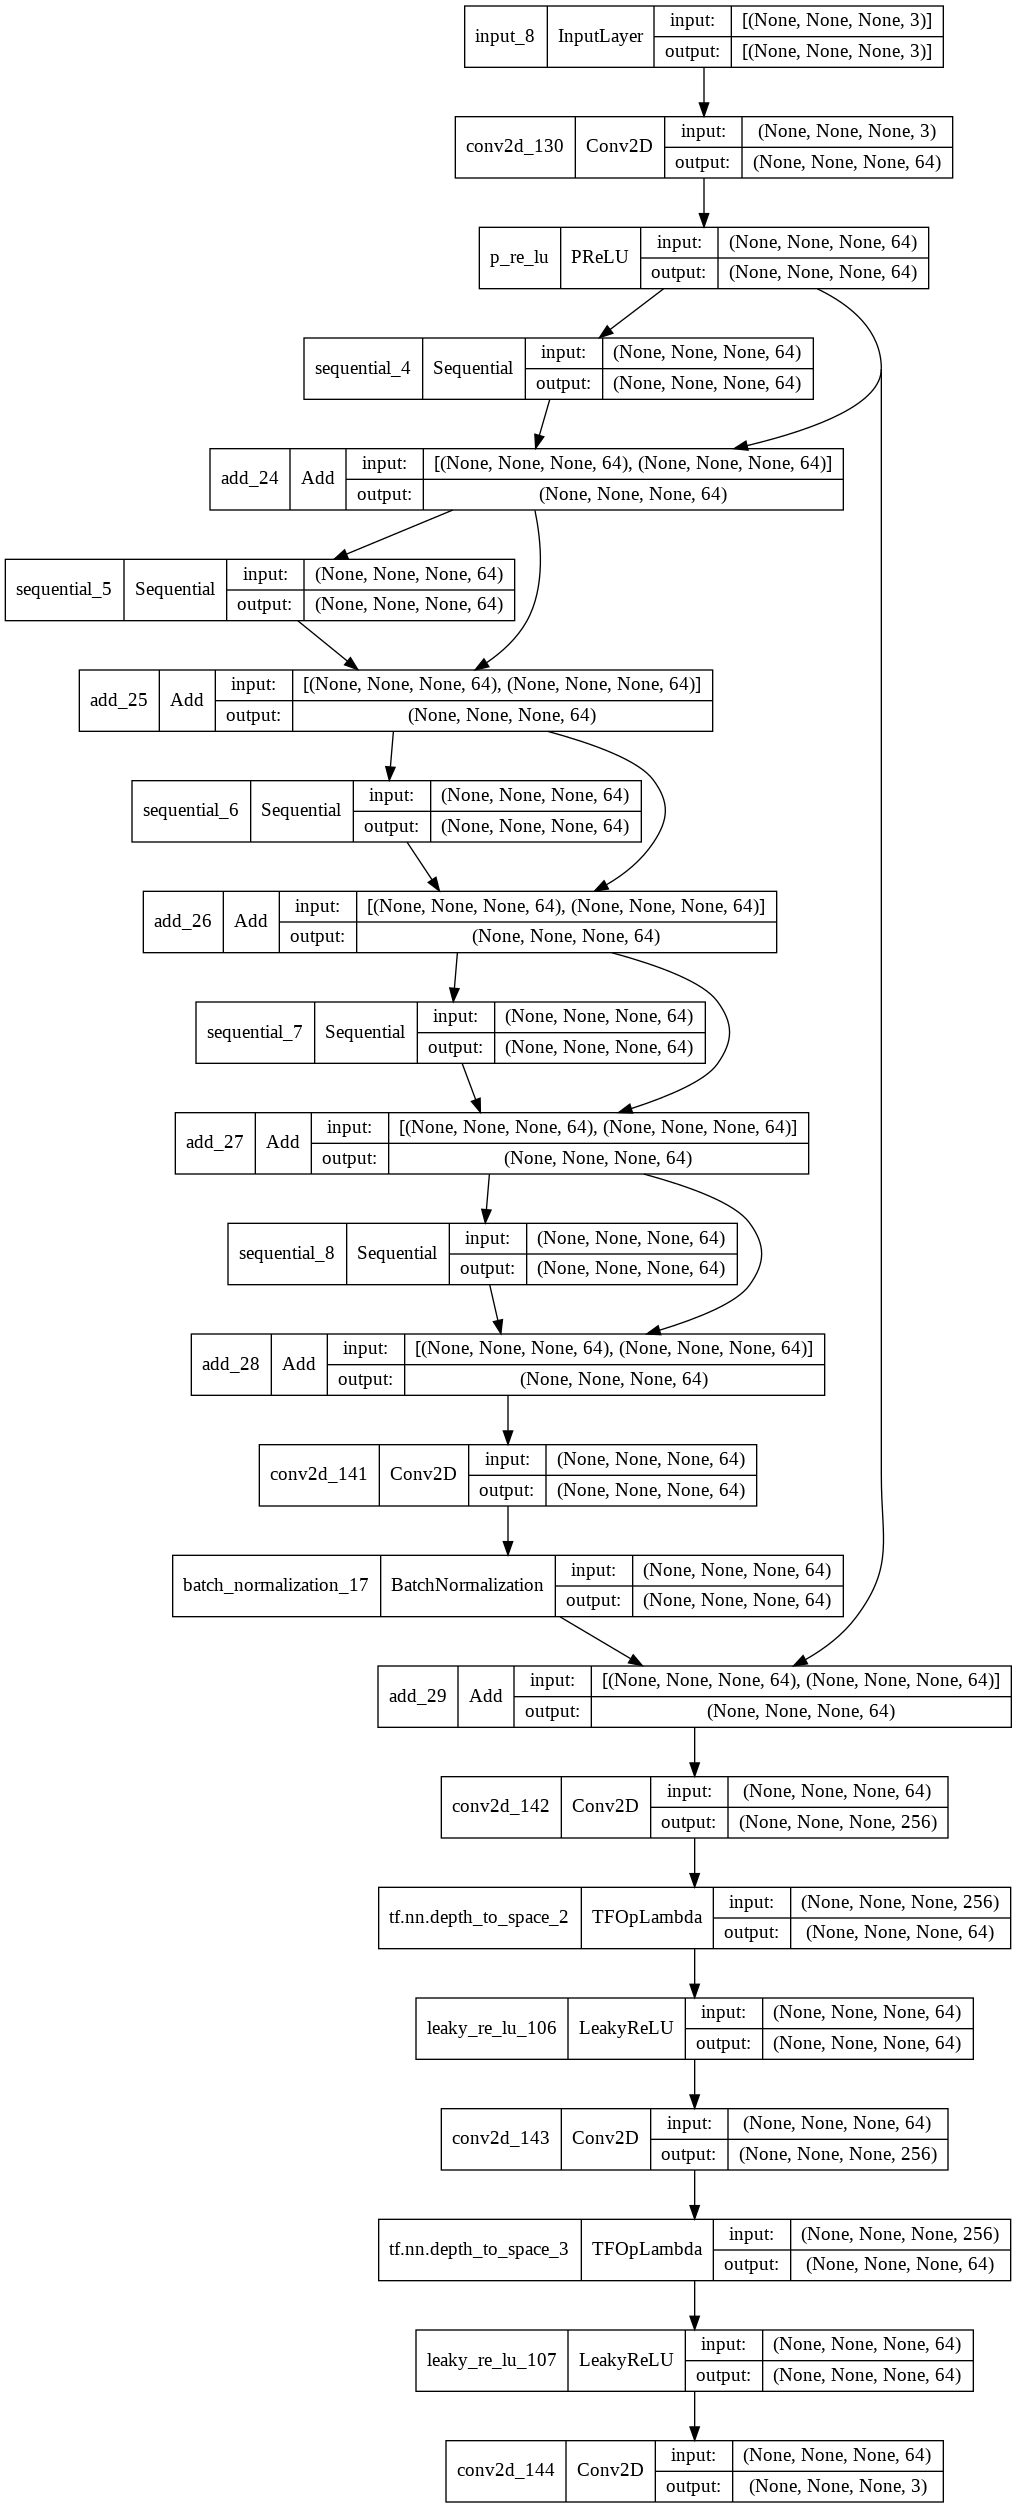

In [ ]:
tf.keras.utils.plot_model(generator,show_shapes=True)

### Enhanced SRGAN(ESRGAN) 

In [ ]:
def residual_block_gen(inp, ch=64,k_s=3,n_blocks=4):
  concat=inp
  for x in range(n_blocks):
    out=tf.keras.layers.Conv2D(ch,k_s,padding='same',kernel_initializer=init)(concat)
    out=tf.keras.layers.LeakyReLU()(out)
    
    concat=tf.keras.layers.concatenate([concat,out])

  out=tf.keras.layers.Conv2D(ch,k_s,padding='same',kernel_initializer=init)(concat)
  return out

def Upsample_block(x, ch=256, k_s=3, st=1):
    x = tf.keras.layers.Conv2D(ch,k_s, strides=(st,st), padding='same',kernel_initializer=init)(x)
    x = tf.nn.depth_to_space(x, 2) # Subpixel pixelshuffler
    x = tf.keras.layers.LeakyReLU()(x)
    return x

residual_scaling=0.2

input_lr=tf.keras.layers.Input(shape=(None,None,3))
input_conv=tf.keras.layers.Conv2D(64,3,padding='same',kernel_initializer=init)(input_lr)
input_conv=tf.keras.layers.LeakyReLU()(input_conv)

ESRRes=input_conv
for x in range(23):
  res_output=residual_block_gen(ESRRes)
  if use_noise:
    res_output=ApplyNoise()(res_output)
  ESRRes=tf.keras.layers.Add()([ESRRes,res_output * residual_scaling])

ESRRes=tf.keras.layers.Conv2D(64,3,padding='same',kernel_initializer=init)(ESRRes)
ESRRes=tf.keras.layers.BatchNormalization()(ESRRes)
ESRRes=tf.keras.layers.Add()([ESRRes,input_conv])

ESRRes=Upsample_block(ESRRes)
ESRRes=Upsample_block(ESRRes)

output_sr=tf.keras.layers.Conv2D(3,3,padding='same',kernel_initializer=init)(ESRRes)

generator=tf.keras.models.Model(input_lr,output_sr)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.777815 to fit



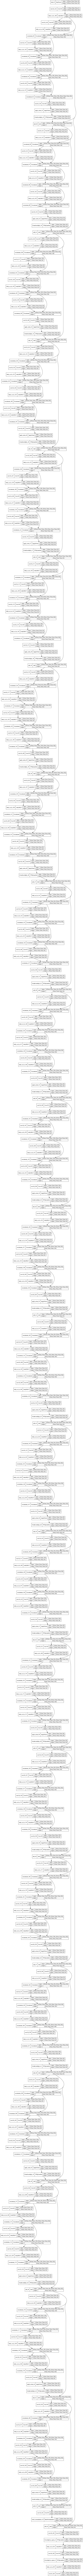

In [ ]:
tf.keras.utils.plot_model(generator, show_shapes=True)

### RCAN

In [ ]:
def mult(x, y):
  return x*y
def RCAN_block(inp, ch=64,k_s=3):
  X=tf.keras.layers.Conv2D(ch,k_s,padding='same',kernel_initializer=init)(inp)
  X=tf.keras.layers.ReLU()(X)
  X=tf.keras.layers.Conv2D(ch,k_s,padding='same',kernel_initializer=init)(X)

  att=tf.keras.layers.GlobalAveragePooling2D()(X)
  att=tf.keras.layers.Dense(ch // r, activation='relu',kernel_initializer=init)(att)
  att=tf.keras.layers.Dense(ch, activation='sigmoid')(att)

  X = tf.keras.layers.multiply([X, att])   
  out = tf.keras.layers.Add()([X, inp])
  return out

def Upsample_block(x, ch=256, k_s=3, st=1):
    x = tf.keras.layers.Conv2D(ch,k_s, strides=(st,st), padding='same',kernel_initializer=init)(x)
    x = tf.nn.depth_to_space(x, 2) 
    x = tf.keras.layers.LeakyReLU()(x)
    return x
    
def Residual_Group(inp, ch=64, k_s=3):
  skip_con=inp
  for x in range(B):
    skip_con=RCAN_block(skip_con)

  out=tf.keras.layers.Conv2D(ch,k_s,padding='same',kernel_initializer=init)(skip_con)
  return tf.keras.layers.Add()([inp, out])

G, B = 2, 2
r=16  #Reduction ratio in Channel attention TODO move to config in later stage of project

input_lr=tf.keras.layers.Input(shape=(None,None,3))
input_conv=tf.keras.layers.Conv2D(64,3,padding='same',kernel_initializer=init)(input_lr)
input_conv=tf.keras.layers.ReLU()(input_conv)

RCAN=input_conv
for x in range(G):
  RCAN=Residual_Group(RCAN)

RCAN=tf.keras.layers.Conv2D(64,3,padding='same',kernel_initializer=init)(RCAN)
RCAN=tf.keras.layers.Add()([RCAN,input_conv])

RCAN=Upsample_block(RCAN)
RCAN=Upsample_block(RCAN)

output_sr=tf.keras.layers.Conv2D(3,3,padding='same',kernel_initializer=init)(RCAN)

generator=tf.keras.models.Model(input_lr,output_sr)

In [ ]:
generator.summary()

Model: "RRDB_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, None, None, 3)]   0         
_________________________________________________________________
conv_first (Conv2D)          multiple                  1792      
_________________________________________________________________
RRDB_trunk (Sequential)      multiple                  0         
_________________________________________________________________
conv_trunk (Conv2D)          multiple                  36928     
_________________________________________________________________
tf_op_layer_add_1 (TensorFlo multiple                  0         
_________________________________________________________________
tf_op_layer_Shape_2 (TensorF multiple                  0         
_________________________________________________________________
tf_op_layer_Shape_3 (TensorF multiple                  0

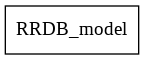

In [ ]:
tf.keras.utils.plot_model(generator, show_shapes=True)

### Progressive Generator

In [ ]:
def Conv_block(inp, ch=64,k_s=3):
  X=tf.keras.layers.Conv2D(ch,k_s,padding='same',kernel_initializer=init)(inp)
  X=tf.keras.layers.LeakyReLU()(X)
  X=tf.keras.layers.Conv2D(ch,k_s,padding='same',kernel_initializer=init)(X)
  X=tf.keras.layers.LeakyReLU()(X)

  out=tf.keras.layers.Add()([X, inp])
  return out

class WeightedSum(tf.keras.layers.Add):
	# init with default value todo move to config later
  def __init__(self, alpha=0.0, **kwargs):
    super(WeightedSum, self).__init__(**kwargs)
    self.alpha = tf.Variable(alpha, name='ws_alpha', trainable=False)
  def _merge_function(self, inputs):
    assert (len(inputs) == 2)
		# ((1-a) * input1) + (a * input2)
    output = ((1.0 - self.alpha) * inputs[0]) + (self.alpha * inputs[1])
    return output

def Upsample_block(x, ch=256, k_s=3, st=1):
    x = tf.keras.layers.Conv2D(ch,k_s, strides=(st,st), padding='same',kernel_initializer=init)(x)
    x = tf.nn.depth_to_space(x, 2) # Subpixel pixelshuffler
    x = tf.keras.layers.LeakyReLU()(x)
    return x

generator_list=[]

upsampling=Upsample_block  #Upsample_block / tf.keras.layers.Conv2DTranspose(64, 4, strides=(2, 2), padding='same') to do move to config option to choose between unsample and conv2dtranspose
g_alpha_list=[]
scale_list=[2, 2, 4, 4]   #Scale array

input_lr=tf.keras.layers.Input(shape=(None,None,3))
input_conv=tf.keras.layers.Conv2D(64,3,padding='same',kernel_initializer=init)(input_lr)
input_conv=tf.keras.layers.LeakyReLU()(input_conv)

old_end = tf.keras.layers.Lambda(lambda x:2*x-1)(input_lr)  #Convert [0, 1] to [-1, 1] 
Prog=Conv_block(input_conv)
for x in range(int(np.log2(LR_SCALE))):
  Prog=upsampling(Prog)
  Prog=Conv_block(Prog)
  new_end=tf.keras.layers.Conv2D(3,3,padding='same',kernel_initializer=init)(Prog)

  upscaled_old=tf.keras.layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(old_end)
  wsum=WeightedSum()
  mixed_output=wsum([upscaled_old, new_end])
  
  g_alpha_list.append(wsum.alpha)
  generator_list.append(tf.keras.models.Model(input_lr, mixed_output))
  
  old_end=new_end
  g_alpha_list.append(None)
  generator_list.append(tf.keras.models.Model(input_lr, new_end))
generator=generator_list[0]

In [ ]:
tf.keras.utils.plot_model(generator_list[0],show_shapes=True)

# Discriminator Architectures

### SRGAN/SRResnet Discriminator

In [13]:
def residual_block_disc(ch=64,k_s=3,st=1):
  model=tf.keras.Sequential([
    tf.keras.layers.Conv2D(ch,k_s,strides=(st,st),padding='same',kernel_initializer=init),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),
  ])
  return model

input_hr=tf.keras.layers.Input(shape=(PATCH_SIZE,PATCH_SIZE,3))

if lr_reference:
  input_lr=tf.keras.layers.Input(shape=(None,None,3))
  input_low=tf.keras.layers.experimental.preprocessing.Resizing(PATCH_SIZE,PATCH_SIZE, interpolation='bicubic')(input_lr)
  inp=tf.keras.layers.concatenate([input_hr, input_low])
else:
  inp=input_hr

input_conv=tf.keras.layers.Conv2D(64,3,padding='same',kernel_initializer=init)(inp)
input_conv=tf.keras.layers.LeakyReLU()(input_conv)

 #Original to do move to config 

channel_nums=[64,128,128,256,256,512,512]
stride_sizes=[2,1,2,1,2,1,2]

'''
# Deep Discriminator:

channel_nums=[64,64,128,128,128,256,256,256,512,512,512,512]
stride_sizes=[1 ,1 ,2  ,1  ,1  ,2  ,1  ,1  ,2  ,1  ,1  ,2]
'''
disc=input_conv
for x in range(len(channel_nums)):
  disc=residual_block_disc(ch=channel_nums[x],st=stride_sizes[x])(disc)
  
disc=tf.keras.layers.Flatten()(disc)

disc=tf.keras.layers.Dense(1024)(disc)
disc=tf.keras.layers.LeakyReLU()(disc)

disc_output=tf.keras.layers.Dense(1)(disc) # <-- RaGAN loss

if lr_reference:
  discriminator=tf.keras.models.Model([input_hr, input_lr],disc_output)
else:
  discriminator=tf.keras.models.Model(input_hr,disc_output)

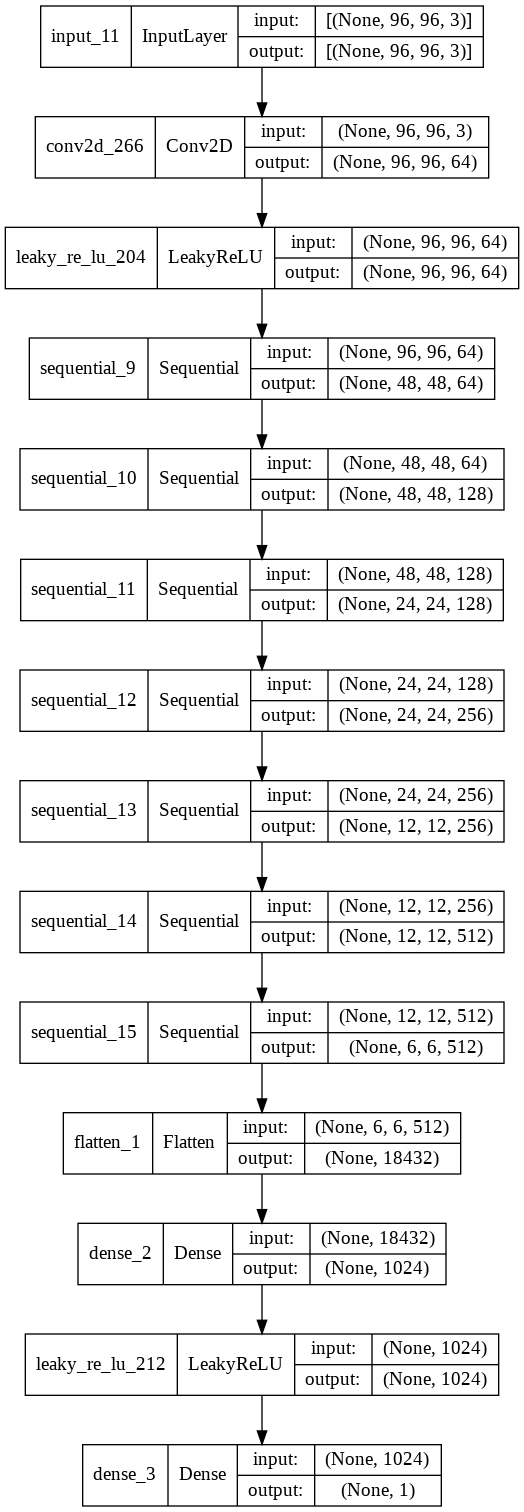

In [ ]:
tf.keras.utils.plot_model(discriminator,show_shapes=True)

### Progressive Discriminator 

In [ ]:
def conv_block(ch=64,k_s=3,st=1):
  model=tf.keras.Sequential([
    tf.keras.layers.Conv2D(ch,k_s,strides=(st,st),padding='same',kernel_initializer=init),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),
  ])
  return model

def build_disc_block(in_image, patch_size, prev_ch=64, ch=64):
  to_rgb = tf.keras.layers.Conv2D(prev_ch, (1,1), padding='same',kernel_initializer=init)(in_image)
  to_rgb = tf.keras.layers.LeakyReLU(alpha=0.2)(to_rgb)

  block_input=tf.keras.layers.Input(shape=to_rgb.shape[1:])
  d = tf.keras.layers.Conv2D(ch, (3,3), padding='same',kernel_initializer=init)(block_input)
  d = tf.keras.layers.BatchNormalization()(d)
  d = tf.keras.layers.LeakyReLU(alpha=0.2)(d)

  d = tf.keras.layers.Conv2D(ch, (3,3), strides=(2,2), padding='same',kernel_initializer=init)(d)
  d = tf.keras.layers.BatchNormalization()(d)
  d = tf.keras.layers.LeakyReLU(alpha=0.2)(d)

  return tf.keras.models.Model(block_input, d), tf.keras.models.Model(in_image, to_rgb)


def build_base_disc():
  input_lr=tf.keras.layers.Input(shape=(PATCH_SIZE //LR_SCALE,PATCH_SIZE //LR_SCALE,3))
  input_conv=tf.keras.layers.Conv2D(128,1,padding='same',kernel_initializer=init)(input_lr)
  input_conv=tf.keras.layers.LeakyReLU()(input_conv)

  channel_nums=[128,256,512,512]
  stride_sizes=[1,2,1,2]

  disc_input=tf.keras.layers.Input(shape=input_conv.shape[1:])
  disc=disc_input
  for x in range(4):
    disc=conv_block(ch=channel_nums[x],st=stride_sizes[x])(disc)
    
  disc=tf.keras.layers.Flatten()(disc)

  disc=tf.keras.layers.Dense(1024)(disc)
  disc=tf.keras.layers.LeakyReLU()(disc)

  disc=tf.keras.layers.Dropout(0.5)(disc)
  disc_output=tf.keras.layers.Dense(1)(disc) s

  return tf.keras.models.Model(disc_input,disc_output), tf.keras.models.Model(input_lr,input_conv)

d_alpha_list=[]
discriminator_list=[]
base_model, from_rgb = build_base_disc()

channel_list=[128,128,64,64,64]
for x in range(int(np.log2(LR_SCALE))):
  cur_size = 2**(x+1) * PATCH_SIZE // LR_SCALE
  in_image = tf.keras.layers.Input(shape=(cur_size, cur_size, 3))

  in_image_down=tf.keras.layers.AveragePooling2D()(in_image)   
  old_in=from_rgb(in_image_down)

  new_model, new_rgb = build_disc_block(in_image, cur_size, prev_ch=channel_list[x+1], ch=channel_list[x])
  new_in = new_model(new_rgb(in_image))
  from_rgb=new_rgb

  wsum=WeightedSum()
  mixed_output=wsum([old_in, new_in])
  mixed_model=tf.keras.models.Model(in_image, base_model(mixed_output))
  base_model=tf.keras.models.Model(new_model.input, base_model(new_model.output))

  d_alpha_list.append(wsum.alpha)
  discriminator_list.append(mixed_model)
  
  d_alpha_list.append(None)
  discriminator_list.append(tf.keras.models.Model(in_image,base_model(new_rgb(in_image))))
discriminator=discriminator_list[0]

NameError: ignored

In [ ]:
tf.keras.utils.plot_model(discriminator_list[0],show_shapes=True)

# Load Weights

In [ ]:
generator=tf.keras.models.load_model('/content/drive/MyDrive/ESRGAN_refGAN_10K/SRGAN_MSE.h5',compile=False)
discriminator=tf.keras.models.load_model('/content/drive/MyDrive/ESRGAN_refGAN_10K/SRGAN_MSE_discriminator.h5',compile=False)
#generator.load_weights('/content/drive/MyDrive/ProgGAN_4x/SRGAN_MSE_Progressive0')
#discriminator.load_weights('/content/drive/MyDrive/ProgGAN_4x/SRGAN_MSE_Progressive0_discriminator')

# Training Functions

## Loss Functions

In [14]:
loss_fn_alex = lpips.LPIPS(net='alex')
def evaluate_PSNR(model, dataset, image_range = 2):
  sum_PSNR, num_images = 0, 0
  for image_pair in dataset:
    lr, hr = image_pair
    sr = model(np.array([lr]))[0]
    hr = tf.image.resize(hr, (sr.shape[0], sr.shape[1]), method = tf.image.ResizeMethod.BICUBIC)
    sum_PSNR += PSNR(hr, sr, image_range = image_range)
    num_images += 1
  return sum_PSNR / num_images

def evaluate_LPIPS(model, dataset):
  sum_LPIPS, num_images = 0, 0
  for image_pair in dataset:
    lr, hr = image_pair
    sr = model(np.array([lr]))[0]
    hr = tf.image.resize(hr, (sr.shape[0], sr.shape[1]), method = tf.image.ResizeMethod.BICUBIC)
    sr, hr=tf.expand_dims(tf.transpose(sr, [2, 0, 1]), axis=0), tf.expand_dims(tf.transpose(hr, [2, 0, 1]), axis=0)
    sum_LPIPS += loss_fn_alex.forward(torch.Tensor(hr.numpy()), torch.Tensor(sr.numpy())) #Calculate LPIPS Similarity
    num_images += 1
  return sum_LPIPS / num_images

def PSNR(y_true,y_pred, image_range = 2):
  mse=tf.reduce_mean( (y_true - y_pred) ** 2 )
  return 20 * log10(image_range / (mse ** 0.5))

def log10(x):
  numerator = tf.math.log(x)
  denominator = tf.math.log(tf.constant(10, dtype=numerator.dtype))
  return numerator / denominator

def pixel_MSE(y_true,y_pred):
  return tf.reduce_mean( (y_true - y_pred) ** 2 )

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

Loading model from: /usr/local/lib/python3.7/dist-packages/lpips/weights/v0.1/alex.pth


In [15]:
VGG19=tf.keras.applications.VGG19(weights='imagenet',include_top=False,input_shape=(None,None,3))

VGG_i,VGG_j=5,4
def VGG_partial(i_m=2,j_m=2):
  i,j=1,0
  accumulated_loss=0.0
  for l in VGG19.layers:
    cl_name=l.__class__.__name__
    if cl_name=='Conv2D':
      j+=1
    if cl_name=='MaxPooling2D':
      i+=1
      j=0
    if i==i_m and j==j_m and cl_name=='Conv2D':
      before_act_output=tf.nn.convolution(l.input, l.weights[0], padding='SAME') + l.weights[1]
      return tf.keras.models.Model(VGG19.input, before_act_output)
partial_VGG=VGG_partial(VGG_i,VGG_j)

80150528/80134624 [==============================] - 1s 0us/step


In [16]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def CE_discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss
    
def CE_generator_loss(real_output, fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def RAGAN_discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output - tf.reduce_mean(fake_output))
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output - tf.reduce_mean(real_output))
    total_loss = (real_loss + fake_loss) / 2
    return total_loss

def RAGAN_generator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.zeros_like(real_output), real_output - tf.reduce_mean(fake_output))
    fake_loss = cross_entropy(tf.ones_like(fake_output), fake_output - tf.reduce_mean(real_output))
    total_loss = (real_loss + fake_loss) / 2
    return total_loss

generator_loss=RAGAN_generator_loss
discriminator_loss=RAGAN_discriminator_loss

## Logging

In [17]:
set5_psnr_list, set14_psnr_list=[],[]
set5_lpips_list, set14_lpips_list=[], []
loss_list={'adv_g':[],'adv_d':[],'reconstruction':[]}

def plot_metrics():
  #Plot PSNR
  if plot_PSNR:
    plt.plot(set5_psnr_list, label='set5')
    plt.plot(set14_psnr_list, label='set14')
    plt.xlabel('Val PSNR')
    plt.legend()
    plt.savefig(os.path.join(log_dir,model_type+'_PSNR.png'))
    plt.close()
  #Plot LPIPS
  if plot_LPIPS:
    plt.plot(set5_lpips_list, label='set5')
    plt.plot(set14_lpips_list, label='set14')
    plt.xlabel('Val PSNR')
    plt.legend()
    plt.savefig(os.path.join(log_dir,model_type+'_LPIPS.png'))
    plt.close()
  #Plot loss function
  plt.plot(loss_list['reconstruction'])
  plt.xlabel('Reconstruction loss')
  plt.savefig(os.path.join(log_dir,model_type+'_loss.png'))
  plt.close()

  #Plot loss function
  if adv_learning:
    plt.plot(loss_list['adv_g'], label='G loss')
    plt.plot(loss_list['adv_d'], label='D loss')
    plt.xlabel('Adversarial Losses')
    plt.legend()
    plt.savefig(os.path.join(log_dir,model_type+'_adversarial.png'))
    plt.close()

  #Plot Set5 examples
  plt.figure(figsize=(15,5 * 5))
  for idx,x in enumerate(set5):
    plt.subplot(5,3,1 + idx * 3)
    plt.imshow(np.clip((x[1] * 0.5 + 0.5).astype(np.float32),0,1))
    plt.axis('off')

    plt.subplot(5,3,2 + idx * 3)
    pred=generator(np.array([x[0]])) * 0.5 + 0.5
    plt.imshow(np.clip(pred[0].numpy().astype(np.float32),0,1))
    plt.axis('off')
    
    plt.subplot(5,3,3 + idx * 3)
    bic=cv2.resize(x[0],(x[1].shape[1],x[1].shape[0]),interpolation=cv2.INTER_CUBIC)
    plt.imshow(np.clip(bic.astype(np.float32),0,1))
    plt.axis('off')

  plt.savefig(os.path.join(log_dir,f'Step_{cur_step}_{model_type}_Set5'))
  plt.close()

  #Plot Set14 examples
  plt.figure(figsize=(15,5 * 14))
  for idx,x in enumerate(set14):
    plt.subplot(14,3,1 + idx * 3)
    plt.imshow(np.clip((x[1] * 0.5 + 0.5).astype(np.float32),0,1))
    plt.axis('off')

    plt.subplot(14,3,2 + idx * 3)
    pred=generator(np.array([x[0]])) * 0.5 + 0.5
    plt.imshow(np.clip(pred[0].numpy().astype(np.float32),0,1))
    plt.axis('off')
    
    plt.subplot(14,3,3 + idx * 3)
    bic=cv2.resize(x[0],(x[1].shape[1],x[1].shape[0]),interpolation=cv2.INTER_CUBIC)
    plt.imshow(np.clip(bic.astype(np.float32),0,1))
    plt.axis('off')

  plt.savefig(os.path.join(log_dir,f'Step_{cur_step}_{model_type}_Set14'))
  plt.close()

## Train Epoch

In [18]:
@tf.function()
def train_step(data,loss_func=pixel_MSE,adv_learning=True,adv_ratio=0.001):
  logs={}
  gen_loss,disc_loss=0,0

  low_resolution,high_resolution=data
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    super_resolution = generator(low_resolution, training=True)
    if progressive_training:
      high_resolution=tf.image.resize(high_resolution, (super_resolution.shape[1], super_resolution.shape[2]), method=tf.image.ResizeMethod.BICUBIC)
    if MSE_after_bicubic:
      sr_lr=tf.image.resize(super_resolution, (PATCH_SIZE//LR_SCALE, PATCH_SIZE//LR_SCALE), method=tf.image.ResizeMethod.BICUBIC)
      gen_loss=loss_func(low_resolution,sr_lr) * content_ratio
    else:
      gen_loss=loss_func(super_resolution, high_resolution) * content_ratio

    logs['reconstruction']=gen_loss
    if adv_learning:
      if lr_reference:
        real_output = discriminator([high_resolution, low_resolution], training=True)
        fake_output = discriminator([super_resolution, low_resolution], training=True)
      else:
        real_output = discriminator(high_resolution, training=True)
        fake_output = discriminator(super_resolution, training=True)

      adv_loss_g = generator_loss(real_output, fake_output) 
      gen_loss += adv_loss_g * adv_ratio

      disc_loss = discriminator_loss(real_output, fake_output)
      
      logs['adv_g']=adv_loss_g
      
      logs['adv_d']=disc_loss

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

  if adv_learning:
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
  return logs

# Training Configuration

In [19]:
generator_optimizer=tf.keras.optimizers.Adam(0.0001)
discriminator_optimizer=tf.keras.optimizers.Adam(0.0001)

adv_ratio=1
content_ratio=10
# # MSE
# loss_func,adv_learning = pixel_MSE,False
# # VGG2.2
# loss_func,adv_learning = lambda y_hr,y_sr:VGG_loss(y_hr,y_sr,i_m=2,j_m=2),False
# # VGG 5.4
# loss_func,adv_learning = lambda y_hr,y_sr:VGG_loss(y_hr,y_sr,i_m=5,j_m=4),False
# # SRGAN-MSE
# loss_func,adv_learning = pixel_MSE,True
# # SRGAN-VGG 2.2
# loss_func,adv_learning = lambda y_hr,y_sr:VGG_loss(y_hr,y_sr,i_m=2,j_m=2),True
# # SRGAN-VGG 5.4
# loss_func,adv_learning = lambda y_hr,y_sr:VGG_loss(y_hr,y_sr,i_m=5,j_m=4),True

#Real loss
loss_func,adv_learning = pixel_MSE,True

## Training Loop

In [20]:
cur_step,max_step=0,10000
progressive_stage,max_prog_stage=0,4
complete=False

pbar=tqdm.tqdm(total=LOG_STEP, position=0, leave=True)
while True:
  image_batch=load_image_batch()
  if progressive_training and not d_alpha_list[progressive_stage] is None:
    d_alpha_list[progressive_stage].assign(cur_step/max_step)
    g_alpha_list[progressive_stage].assign(cur_step/max_step)
  logs=train_step(image_batch,loss_func,adv_learning,adv_ratio)

  pbar.update(1)
  cur_step+=1

  
  if cur_step%LOG_STEP==0: #Every log step 
    tf.keras.backend.clear_session()
    gc.collect()
    if plot_PSNR:
      set5_psnr=evaluate_PSNR(generator, set5)
      set14_psnr=evaluate_PSNR(generator, set14)

      set5_psnr_list.append(set5_psnr)
      set14_psnr_list.append(set14_psnr)

    if plot_LPIPS:
      set5_lpips=evaluate_LPIPS(generator, set5)
      set14_lpips=evaluate_LPIPS(generator, set14)

      set5_lpips_list.append(set5_lpips)
      set14_lpips_list.append(set14_lpips)

    for x in logs.keys():
      loss_list[x].append(logs[x])

    print('Step',cur_step,'/',max_step)
    pbar.reset()
    plot_metrics()
    if progressive_training:
      generator.save_weights(os.path.join(log_dir,model_type+'_Progressive'+str(progressive_stage)))
    else:
      generator.save(os.path.join(log_dir,model_type))
    
    if adv_learning:
      if progressive_training:
        discriminator.save_weights(os.path.join(log_dir,model_type+'_Progressive'+str(progressive_stage)+'_discriminator'))
      else:
        discriminator.save(os.path.join(log_dir,model_type+'_discriminator'))    
      
  if cur_step==max_step:    #Complete end of training
    if progressive_training and adv_learning:    #Current progressive growing end
      progressive_stage+=1
      cur_step=0
      if progressive_stage==max_prog_stage:   #Complete end of training
        break
      generator=generator_list[progressive_stage]
      discriminator=discriminator_list[progressive_stage]
    else:     #Complete end of training
      break

  0%|          | 0/1000 [00:00<?, ?it/s]           

Step 1000 / 10000
INFO:tensorflow:Assets written to: /content/drive/MyDrive/logs/Ultimate-SR/ESRGAN-MSE-100K/SRGAN_MSE/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/logs/Ultimate-SR/ESRGAN-MSE-100K/SRGAN_MSE_discriminator/assets


  0%|          | 0/1000 [00:00<?, ?it/s]           

Step 2000 / 10000
INFO:tensorflow:Assets written to: /content/drive/MyDrive/logs/Ultimate-SR/ESRGAN-MSE-100K/SRGAN_MSE/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/logs/Ultimate-SR/ESRGAN-MSE-100K/SRGAN_MSE_discriminator/assets


  0%|          | 0/1000 [00:00<?, ?it/s]           

Step 3000 / 10000
INFO:tensorflow:Assets written to: /content/drive/MyDrive/logs/Ultimate-SR/ESRGAN-MSE-100K/SRGAN_MSE/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/logs/Ultimate-SR/ESRGAN-MSE-100K/SRGAN_MSE_discriminator/assets


  0%|          | 0/1000 [00:00<?, ?it/s]           

Step 4000 / 10000
INFO:tensorflow:Assets written to: /content/drive/MyDrive/logs/Ultimate-SR/ESRGAN-MSE-100K/SRGAN_MSE/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/logs/Ultimate-SR/ESRGAN-MSE-100K/SRGAN_MSE_discriminator/assets


  0%|          | 0/1000 [00:00<?, ?it/s]           

Step 5000 / 10000
INFO:tensorflow:Assets written to: /content/drive/MyDrive/logs/Ultimate-SR/ESRGAN-MSE-100K/SRGAN_MSE/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/logs/Ultimate-SR/ESRGAN-MSE-100K/SRGAN_MSE_discriminator/assets


  0%|          | 0/1000 [00:00<?, ?it/s]           

Step 6000 / 10000
INFO:tensorflow:Assets written to: /content/drive/MyDrive/logs/Ultimate-SR/ESRGAN-MSE-100K/SRGAN_MSE/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/logs/Ultimate-SR/ESRGAN-MSE-100K/SRGAN_MSE_discriminator/assets


  0%|          | 0/1000 [00:00<?, ?it/s]           

Step 7000 / 10000
INFO:tensorflow:Assets written to: /content/drive/MyDrive/logs/Ultimate-SR/ESRGAN-MSE-100K/SRGAN_MSE/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/logs/Ultimate-SR/ESRGAN-MSE-100K/SRGAN_MSE_discriminator/assets


  0%|          | 0/1000 [00:00<?, ?it/s]           

Step 8000 / 10000
INFO:tensorflow:Assets written to: /content/drive/MyDrive/logs/Ultimate-SR/ESRGAN-MSE-100K/SRGAN_MSE/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/logs/Ultimate-SR/ESRGAN-MSE-100K/SRGAN_MSE_discriminator/assets


  0%|          | 0/1000 [00:00<?, ?it/s]           

Step 9000 / 10000
INFO:tensorflow:Assets written to: /content/drive/MyDrive/logs/Ultimate-SR/ESRGAN-MSE-100K/SRGAN_MSE/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/logs/Ultimate-SR/ESRGAN-MSE-100K/SRGAN_MSE_discriminator/assets


  0%|          | 0/1000 [00:00<?, ?it/s]           

Step 10000 / 10000
INFO:tensorflow:Assets written to: /content/drive/MyDrive/logs/Ultimate-SR/ESRGAN-MSE-100K/SRGAN_MSE/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/logs/Ultimate-SR/ESRGAN-MSE-100K/SRGAN_MSE_discriminator/assets


In [21]:
generator.save('SRResNet-generator.h5')
discriminator.save('SRResNet-discriminator.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


# Evaluation

In [1]:
for im in set5:
  fig=plt.figure(figsize=(20,5))
  plt.subplot(1,3,1)
  plt.imshow(im[1]*0.5+0.5)
  plt.axis('off')

  plt.subplot(1,3,3)
  lr=tf.image.resize(im[0], (im[1].shape[0], im[1].shape[1]),method=tf.image.ResizeMethod.BICUBIC)
  plt.imshow(lr)
  plt.axis('off')

  plt.subplot(1,3,2)
  lr=imresize_np(im[1] * 0.5 + 0.5, 0.25)
  pred=generator(np.array([lr]))
  
  plt.imshow(pred[0].numpy()*0.5+0.5)
  plt.axis('off')

  plt.show()
  print('Bicubic PSNR:',PSNR(im[1],lr * 2 - 1),'  Generator PSNR:',PSNR(im[1],pred))

NameError: ignored

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


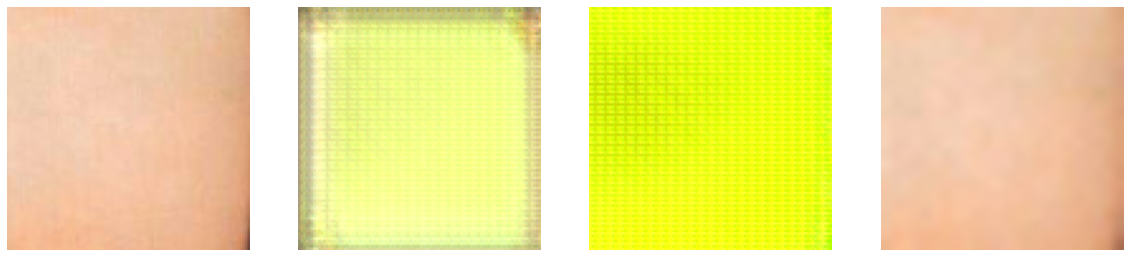

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Bicubic PSNR: tf.Tensor(39.58726, shape=(), dtype=float32)   Generator PSNR cropped: tf.Tensor(15.297123, shape=(), dtype=float32)   Generator PSNR total: tf.Tensor(13.773669, shape=(), dtype=float32)


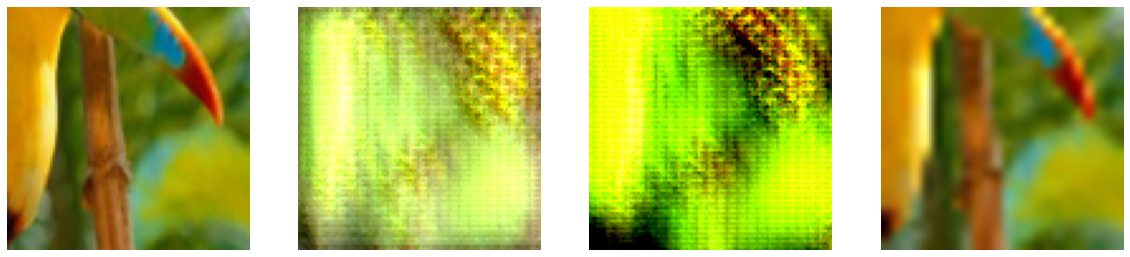

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Bicubic PSNR: tf.Tensor(27.700317, shape=(), dtype=float32)   Generator PSNR cropped: tf.Tensor(8.817409, shape=(), dtype=float32)   Generator PSNR total: tf.Tensor(7.582673, shape=(), dtype=float32)


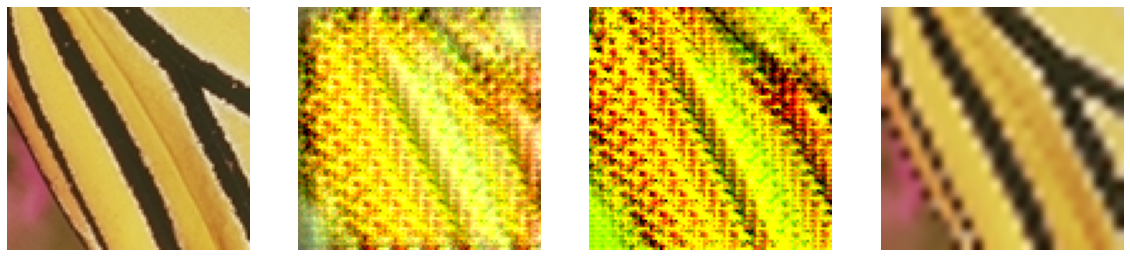

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Bicubic PSNR: tf.Tensor(21.003887, shape=(), dtype=float32)   Generator PSNR cropped: tf.Tensor(8.37302, shape=(), dtype=float32)   Generator PSNR total: tf.Tensor(8.137003, shape=(), dtype=float32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


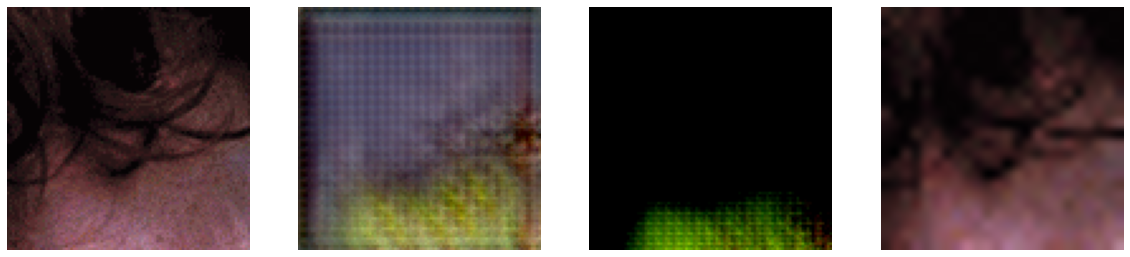

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Bicubic PSNR: tf.Tensor(29.764242, shape=(), dtype=float32)   Generator PSNR cropped: tf.Tensor(13.5923195, shape=(), dtype=float32)   Generator PSNR total: tf.Tensor(12.301449, shape=(), dtype=float32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


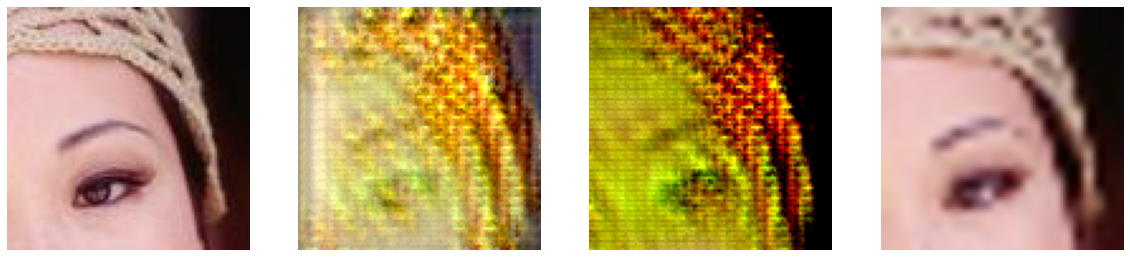

Bicubic PSNR: tf.Tensor(24.416056, shape=(), dtype=float32)   Generator PSNR cropped: tf.Tensor(11.481558, shape=(), dtype=float32)   Generator PSNR total: tf.Tensor(11.833514, shape=(), dtype=float32)


In [23]:

for im in set5:
  fig=plt.figure(figsize=(20,5))
  x_idx, y_idx = np.random.randint(0,im[1].shape[0]-PATCH_SIZE), np.random.randint(0,im[1].shape[1]-PATCH_SIZE)
  random_crop=im[1][x_idx:x_idx+PATCH_SIZE, y_idx:y_idx+PATCH_SIZE] * 0.5 + 0.5
  lr_crop=tf.image.resize(random_crop, (PATCH_SIZE//LR_SCALE, PATCH_SIZE//LR_SCALE),method=tf.image.ResizeMethod.BICUBIC)

  plt.subplot(1,4,1)
  plt.imshow(random_crop)
  plt.axis('off')

  plt.subplot(1,4,4)
  lr=tf.image.resize(lr_crop, (PATCH_SIZE, PATCH_SIZE),method=tf.image.ResizeMethod.BICUBIC)
  plt.imshow(lr)
  plt.axis('off')

  plt.subplot(1,4,2)#Reconstruced on cropped patch
  pred_cropped=generator(np.array([lr_crop]))[0]
  plt.imshow(pred_cropped*0.5+0.5)
  plt.axis('off')

  plt.subplot(1,4,3)#Crop of reconstructed from total image
  pred_total=generator(np.array([im[0]]))[0,x_idx:x_idx+PATCH_SIZE, y_idx:y_idx+PATCH_SIZE]
  plt.imshow(pred_total )
  plt.axis('off')

  plt.show()
  #print(x['image'].numpy(),lr)
  print('Bicubic PSNR:',PSNR(random_crop * 2 - 1, lr * 2 - 1),'  Generator PSNR cropped:',PSNR(random_crop * 2 - 1,pred_cropped),'  Generator PSNR total:',PSNR(random_crop * 2 - 1,pred_total))